# JC3503 Assignment - Apartments

---

Student Name: 

Student Email: 

Student ID: 

---

Additional information about the dataset: https://archive.ics.uci.edu/dataset/555/apartment+for+rent+classified

In [44]:
# Add any pre-requisites or libraries here
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn import linear_model

# Import the data
df = pd.read_csv("apartments.csv", low_memory=False)

Start with a glance at the data

In [45]:
df.head()

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668640009,housing/rent/apartment,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, R...",NaN,1.0,1.0,USD,No,Thumbnail,...,"$2,195",Monthly,542,507 509 Esplanade,Redondo Beach,CA,33.8520,-118.3759,RentLingo,1577360355
1,5668639818,housing/rent/apartment,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Ne...",NaN,1.5,3.0,USD,No,Thumbnail,...,"$1,250",Monthly,1500,146 Lochview Dr,Newport News,VA,37.0867,-76.4941,RentLingo,1577360340
2,5668639686,housing/rent/apartment,Three BR 3101 Morningside Drive,This unit is located at 3101 Morningside Drive...,NaN,2.0,3.0,USD,No,Thumbnail,...,"$1,395",Monthly,1650,3101 Morningside Dr,Raleigh,NC,35.8230,-78.6438,RentLingo,1577360332
3,5668639659,housing/rent/apartment,Two BR 209 Aegean Way,"This unit is located at 209 Aegean Way, Vacavi...",NaN,1.0,2.0,USD,No,Thumbnail,...,"$1,600",Monthly,820,209 Aegean Way,Vacaville,CA,38.3622,-121.9712,RentLingo,1577360330
4,5668639374,housing/rent/apartment,One BR 4805 Marquette NE,"This unit is located at 4805 Marquette NE, Alb...",NaN,1.0,1.0,USD,No,Thumbnail,...,$975,Monthly,624,4805 Marquette NE,Albuquerque,NM,35.1038,-106.6110,RentLingo,1577360308


# 1. Data pre-processing
The two parameters of currency and price type may cause inconsistency in the data units, so we will convert the data units into consistency first

## 1.1 Check currency

In [46]:
# Calculate the number of elements in the currency
df['currency'].value_counts()

USD    99492
Name: currency, dtype: int64

We are pleased to find that the currencies are in USD and do not need to be converted

## 1.2 Check price_type

In [47]:
# Calculate the number of elements in the price type
df['price_type'].value_counts()

Monthly           99488
Weekly                3
Monthly|Weekly        1
Name: price_type, dtype: int64

We convert all prices into monthly

In [48]:
# Multiply the weekly price by 4 to get the monthly price
df.loc[df['price_type'] == 'Weekly', 'price'] *= 4
# At the same time, change the price type to monthly
df.loc[df['price_type'] == 'Weekly', 'price_type'] = 'Monthly'
df['price_type'].value_counts()

Monthly           99491
Monthly|Weekly        1
Name: price_type, dtype: int64

In [49]:
# df['number_of_amenities'] = df['amenities'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# 2. Data cleaning
We want to clean the data, fill in the empty data, and find the wrong data.
Let's start by looking at the distribution of key data

In [50]:
df[['price', 'square_feet', 'bedrooms', 'bathrooms']].describe(percentiles=[.005, .25, .5, .75, .995])

,price,square_feet,bedrooms,bathrooms
count,99491.000000,99492.000000,99368.000000,99429.000000
mean,1527.386256,956.430688,1.728212,1.445323
std,909.958608,417.571522,0.749200,0.547021
min,100.000000,101.000000,0.000000,1.000000
0.5%,500.000000,319.000000,0.000000,1.000000
25%,1013.000000,729.000000,1.000000,1.000000
50%,1350.000000,900.000000,2.000000,1.000000
75%,1795.000000,1115.000000,2.000000,2.000000
99.5%,5000.000000,2746.000000,4.000000,3.000000
max,52500.000000,50000.000000,9.000000,9.000000


Fill all empty spaces with the median

In [51]:
df['price'].fillna(df['price'].median(), inplace=True)
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
df['square_feet'].fillna(df['square_feet'].median(), inplace=True)

# 3. Data analysis

In [52]:
# Setup plot
sns.set_theme()
%matplotlib inline

## 3.1 Relationship between 'square_feet' and 'price'
### 3.1.1 Relationship on origin data
First we draw a scatter plot base on square feet and price

<AxesSubplot:xlabel='square_feet', ylabel='price'>

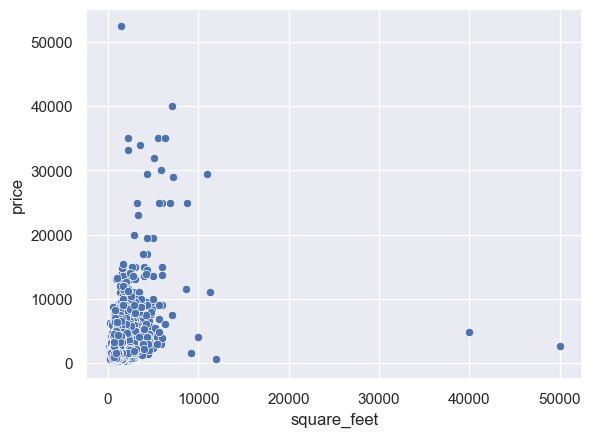

In [53]:
sns.scatterplot(x='square_feet', y='price', data=df)

It is not difficult to see that our data is concentrated in the lower left corner, and some data is too far away from the main data group. Look for extreme or erroneous data. From the above statistics found that 0.5 percent to 99.5 percent of the data is priced between 500 dollars and 5,000 dollars, and the area is between 319 and 2,746 feet. Let's focus on the data in this range. And draw a scatter plot again.

<AxesSubplot:xlabel='square_feet', ylabel='price'>

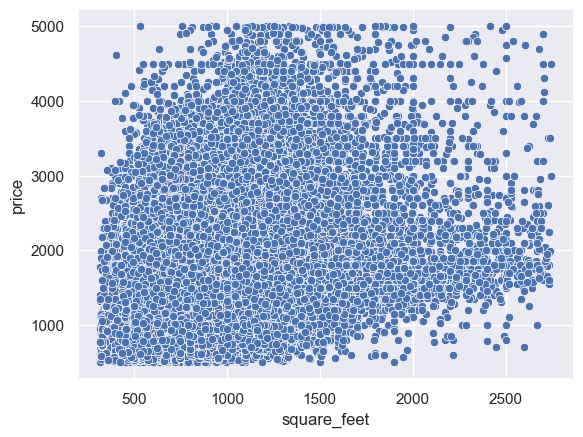

In [54]:
# Calculate the endpoint value and save it to a variable
price_point_5_percentile = df['price'].quantile(0.005)
price_99_point_5_percentile = df['price'].quantile(0.995)
square_feet_point_5_percentile = df['square_feet'].quantile(0.005)
square_feet_99_point_5_percentile = df['square_feet'].quantile(0.995)
# print(price_point_5_percentile,price_99_point_5_percentile)

# Get the data within the interval
df = df[(df['price'] >= price_point_5_percentile) & (df['price'] <= price_99_point_5_percentile)]
df = df[
    (df['square_feet'] >= square_feet_point_5_percentile) & (df['square_feet'] <= square_feet_99_point_5_percentile)]

sns.scatterplot(x='square_feet', y='price', data=df)

Overall, there is little correlation between home size and rental prices. Let's try to control for variables that look at the price of homes in a state, and control for consistent conditions for surrounding amenities and pets.
Let's take a look at the top five states, pets allowed, and amenities.

In [55]:
top_5_states = df['state'].value_counts().head(5)
top_5_pets_allowed = df['pets_allowed'].value_counts().head(5)
top_5_amenities = df['amenities'].value_counts().head(5)

print(top_5_states)
print(top_5_pets_allowed)
print(top_5_amenities)

# most_common_state = top_5_states.index[0]

TX    11190
CA     9866
VA     8238
CO     6217
NC     6216
Name: state, dtype: int64
Cats,Dogs         36727
Cats               1808
Dogs                117
Cats,Dogs,None        1
Name: pets_allowed, dtype: int64
Parking             6096
Parking,Storage     2107
Gym,Pool            1864
Pool                1424
Gym,Parking,Pool    1182
Name: amenities, dtype: int64


### 3.1.2 Relationship on selected data
Let's choose two sub data sets, the variable is TX State, the amenities is "Parking", and the pets allowed are "Cats, Dogs" and empty respectively.

In [56]:
# Select data by conditions
TX_CatAndDogs_Parking = df[
    (df['state'] == 'TX') & (df['pets_allowed'] == 'Cats,Dogs') & (df['amenities'] == 'Parking')]
TX_None_Parking = df[
    (df['state'] == 'TX') & (df['pets_allowed'].isna()) & (df['amenities'] == 'Parking')]

# Show the data set shape
print(TX_CatAndDogs_Parking.shape)
print(TX_None_Parking.shape)

(110, 22)
(470, 22)


<AxesSubplot:xlabel='square_feet', ylabel='price'>

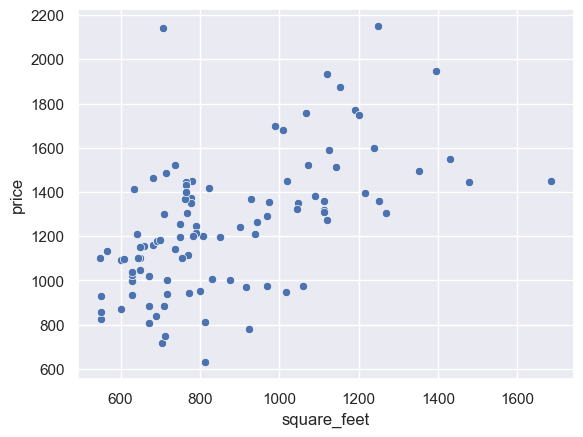

In [57]:
sns.scatterplot(x='square_feet', y='price', data=TX_CatAndDogs_Parking)

<AxesSubplot:xlabel='square_feet', ylabel='price'>

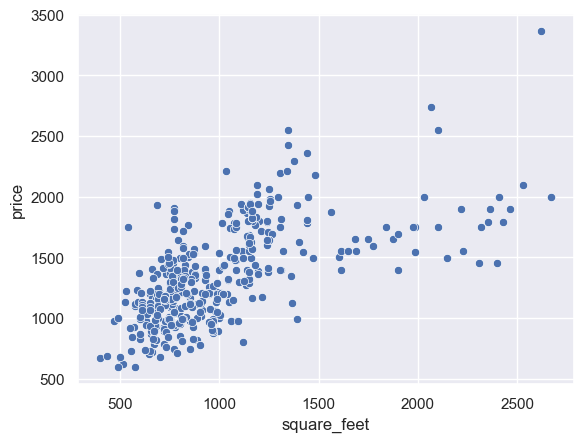

In [58]:
sns.scatterplot(x='square_feet', y='price', data=TX_None_Parking)

By controlling the variables, we can find that there is a linear relationship between the size of the house and the price. Let's calculate their correlation coefficients.

In [59]:
main_set_corr = df[['price', 'square_feet']].corr()
subset_1_corr = TX_CatAndDogs_Parking[['price', 'square_feet']].corr()
subset_2_corr = TX_None_Parking[['price', 'square_feet']].corr()

print("Corr of origin set:\n", main_set_corr)
print("Corr of subset 1:\n", subset_1_corr)
print("Corr of subset 2:\n", subset_2_corr)

Corr of origin set:
                 price  square_feet
price        1.000000     0.332011
square_feet  0.332011     1.000000
Corr of subset 1:
                 price  square_feet
price        1.000000     0.526499
square_feet  0.526499     1.000000
Corr of subset 2:
                 price  square_feet
price        1.000000     0.643035
square_feet  0.643035     1.000000


According to the above output results, the correlation coefficient between housing area and rental price of the data subset we selected is significantly higher than that of the original data set.

### 3.1.3 Regression on selected data

Now let's try to do a regression analysis of house size and rental price for the sub datasets.

In [60]:
# Computing linear model on TX_CatAndDogs_Parking dataset
# Note we need to do some reshaping of the data here
subset1_x = TX_CatAndDogs_Parking['square_feet'].values.reshape(-1,1)
subset1_y = TX_CatAndDogs_Parking['price'].values.reshape(-1,1)

# Compute linear model
subset1_lm = linear_model.LinearRegression().fit(subset1_x, subset1_y)

print('TX_CatAndDogs_Parking dataset\'s linear model:')
print("Intercept: ", subset1_lm.intercept_[0]) 
print("Coefficient: ", subset1_lm.coef_[0][0])
print("R-Squared: ", subset1_lm.score(subset1_x, subset1_y))

TX_CatAndDogs_Parking dataset's linear model:
Intercept:  658.6884437683669
Coefficient:  0.6623126480956187
R-Squared:  0.2772011192690147


In [61]:
# Computing linear model on TX_CatAndDogs_Parking dataset

subset2_x = TX_None_Parking['square_feet'].values.reshape(-1,1)
subset2_y = TX_None_Parking['price'].values.reshape(-1,1)

# Compute linear model
subset2_lm = linear_model.LinearRegression().fit(subset2_x, subset2_y)

print('TX_None_Parking dataset\'s linear model:')
print("Intercept: ", subset2_lm.intercept_[0]) 
print("Coefficient: ", subset2_lm.coef_[0][0])
print("R-Squared: ", subset2_lm.score(subset1_x, subset1_y))

TX_None_Parking dataset's linear model:
Intercept:  689.8794521062418
Coefficient:  0.6340168062090268
R-Squared:  0.2762346989871213


<AxesSubplot:xlabel='square_feet', ylabel='price'>

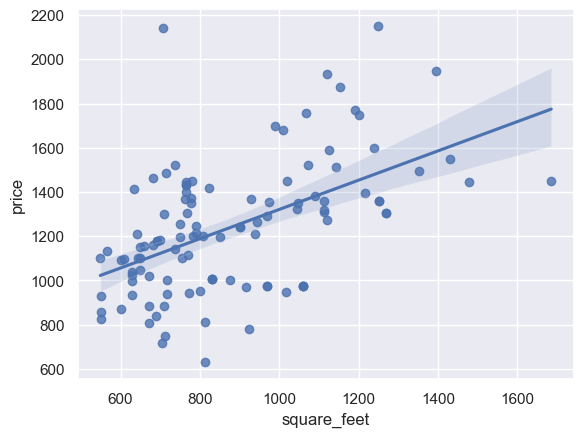

In [62]:
sns.regplot(x='square_feet', y='price', data=TX_CatAndDogs_Parking)

It can be seen that most of the data is distributed near the regression line, although the linear relationship is not strong. But we can still find a positive correlation between rental prices and home size.

### 3.1.4 Conclusion

By filtering the data for controlled conditions, we can find a linear relationship between rental price and home size. Generally speaking, other things being equal, rental prices increase with the size of the house. In different states, different amenities, and different pet conditions, rental prices increase by different amounts with the size of the home. For example, in the two sub datasets above, for homes with parking Spaces in TX states, rental prices for homes that allow dogs and cats increased more with house size than for homes that do not allow pets.


## 3.2 Relationships between 'square feet' and 'bedrooms' and 'bathrooms' 
Let's explore the relationship between house size and number of bathrooms, and house size and number of bedrooms, respectively.

### 3.2.1 Square feet and number of bedrooms.

<AxesSubplot:xlabel='square_feet', ylabel='bedrooms'>

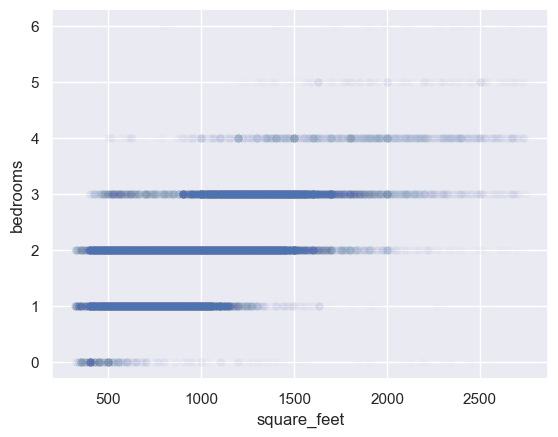

In [63]:
sns.scatterplot(x='square_feet', y='bedrooms', data=df, alpha=0.01)

In a scatter plot, the darker the color, the denser the data. We can find that as the size of the house increases, the number of bedrooms seems to increase. The trend is not obvious. Let's draw a KDE diagram to better show the data density.

<AxesSubplot:xlabel='square_feet', ylabel='bedrooms'>

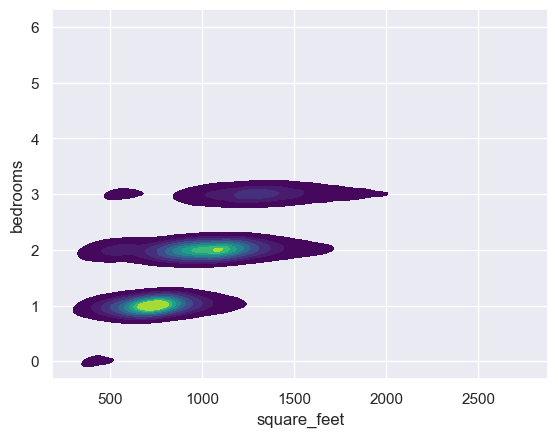

In [64]:
sns.kdeplot(x='square_feet', y='bedrooms', data=df, cmap='viridis', fill=True)

From the KDE chart, we can better see that the number of bedrooms is positively correlated with the size of the house. And we found that the vast majority of houses have three bedrooms or fewer. Most houses with a size of 500 square feet have one bedroom, and most houses with a size of 1000 square feet have two bedrooms.
What if we were to plot with the sub data set above?

<AxesSubplot:xlabel='square_feet', ylabel='bedrooms'>

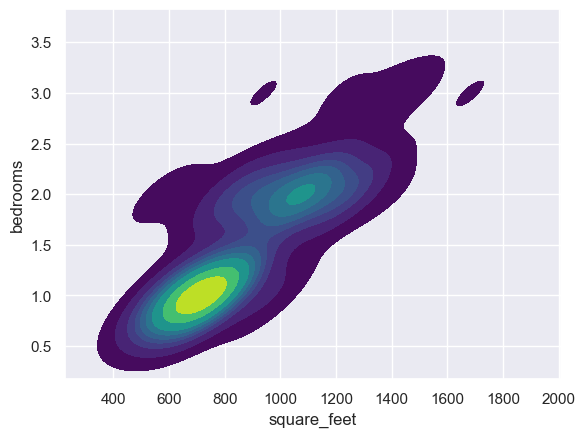

In [65]:
sns.kdeplot(x='square_feet', y='bedrooms', data=TX_CatAndDogs_Parking, cmap='viridis', fill=True)

<AxesSubplot:xlabel='square_feet', ylabel='bedrooms'>

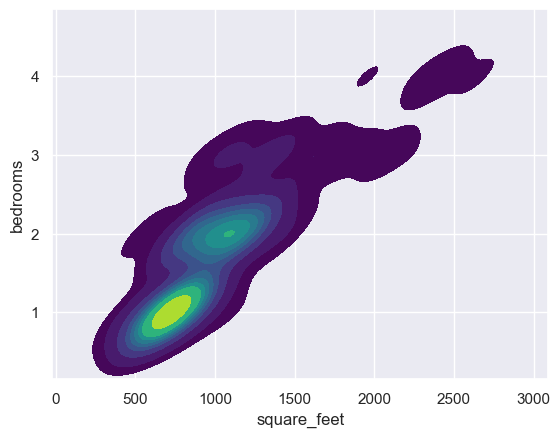

In [66]:
sns.kdeplot(x='square_feet', y='bedrooms', data=TX_None_Parking, cmap='viridis', fill=True)

An even clearer trend has emerged. Bigger houses have more bedrooms.
### 3.2.2 Square feet and number of bathrooms
Let's do the same with the number of bathrooms.

<AxesSubplot:xlabel='square_feet', ylabel='bathrooms'>

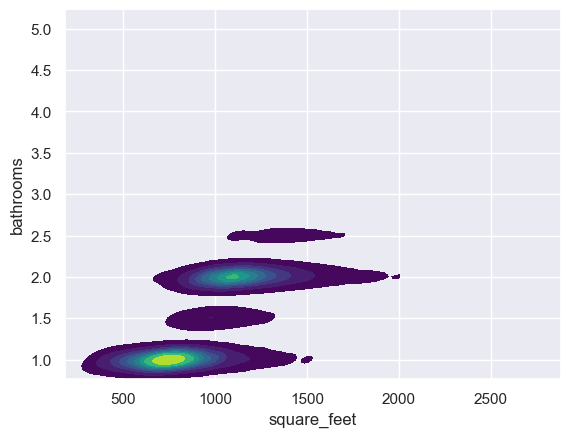

In [67]:
sns.kdeplot(x='square_feet', y='bathrooms', data=df, cmap='viridis', fill=True)

In terms of data density, most houses have 1 to 2 bathrooms, and houses with more than 3 bathrooms are very rare. At the same time, the number of bathrooms also has a weak positive correlation with the size of the house.
We select two sub-data sets for analysis through control variables.

In [68]:
# Select data by conditions
CA_Cats_None = df[
    (df['state'] == 'CA') & (df['pets_allowed'] == 'Cats')]
VA_None_Parking = df[
    (df['state'] == 'VA') & (df['pets_allowed'].isna()) & (df['amenities'] == 'Parking')]

# Show the data set shape
print(CA_Cats_None.shape)
print(VA_None_Parking.shape)

(265, 22)
(518, 22)


<AxesSubplot:xlabel='square_feet', ylabel='bathrooms'>

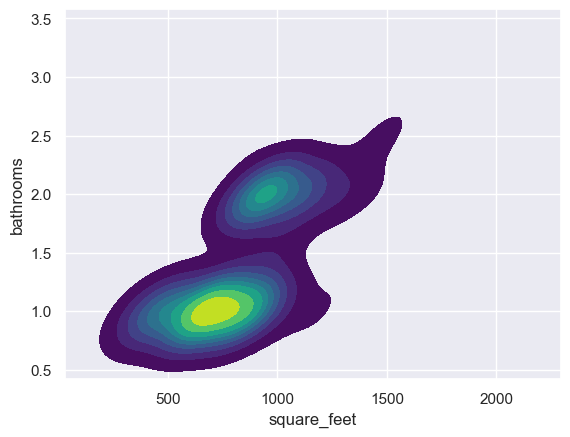

In [69]:
sns.kdeplot(x='square_feet', y='bathrooms', data=CA_Cats_None, cmap='viridis', fill=True)

<AxesSubplot:xlabel='square_feet', ylabel='bathrooms'>

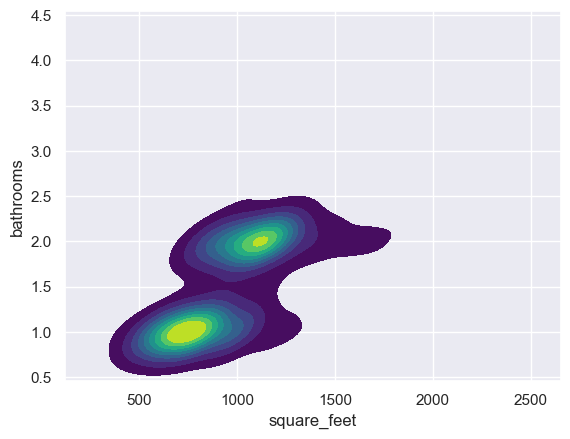

In [70]:
sns.kdeplot(x='square_feet', y='bathrooms', data=VA_None_Parking, cmap='viridis', fill=True)

We selected data on houses in CA states that allow cats and VA states that do not allow cats and have only parking facilities. Looking at the density map, they show almost the same trend.
### 3.2.3 Conclusion
Finally, let's calculate the correlation coefficient.


In [71]:
main_set_square_bedrooms_bathrooms_corr = df[['square_feet','bedrooms', 'bathrooms']].corr()
subset_3_square_bedrooms_bathrooms_corr = CA_Cats_None[['square_feet','bedrooms', 'bathrooms']].corr()
subset_4_square_bedrooms_bathrooms_corr = VA_None_Parking[['square_feet','bedrooms', 'bathrooms']].corr()

print("Corr of origin set:\n", main_set_square_bedrooms_bathrooms_corr)
print("Corr of subset 3:\n", subset_3_square_bedrooms_bathrooms_corr)
print("Corr of subset 4:\n", subset_4_square_bedrooms_bathrooms_corr)

Corr of origin set:
              square_feet  bedrooms  bathrooms
square_feet     1.000000  0.711451   0.721479
bedrooms        0.711451  1.000000   0.662099
bathrooms       0.721479  0.662099   1.000000
Corr of subset 3:
              square_feet  bedrooms  bathrooms
square_feet     1.000000  0.626421   0.692383
bedrooms        0.626421  1.000000   0.666589
bathrooms       0.692383  0.666589   1.000000
Corr of subset 4:
              square_feet  bedrooms  bathrooms
square_feet     1.000000  0.598330   0.697886
bedrooms        0.598330  1.000000   0.618359
bathrooms       0.697886  0.618359   1.000000


From the above picture and the final correlation coefficient calculation, we can confirm that the number of bedrooms and the number of bathrooms have a positive correlation with the size of the house.

## 3.3 House prices by state?
Now let's calculate the average house price in each state.
For more detailed data, we grouped the data not only by state, but also by house size.

In [72]:
# Prepare to group. Label the data by the size of the house.
square_feet_bins = pd.cut(df['square_feet'], bins=[0, 1000, 2000, 3000], labels=['0-1000', '1000-2000', '2000-3000'])
# Add the label back to the data set.
df['square_feet_group'] = square_feet_bins

# Group data by state and label
# Average rental prices are calculated using grouped data.
# Then convert the data format back to DataFrame
grouped = df.groupby(['state', 'square_feet_group']).apply(lambda x: x['price'].sum() / x['square_feet'].sum()).reset_index()


# Process the calculated data and present it
grouped.columns = ['state', 'square_feet_group', 'avg_price_per_sqft']
average_price_df = grouped.pivot(index='state', columns='square_feet_group', values='avg_price_per_sqft').fillna(0)

In [73]:
average_price_df.describe()

square_feet_group,0-1000,1000-2000,2000-3000
count,51.000000,51.000000,51.000000
mean,1.540408,1.276121,0.816200
std,0.568375,0.407031,0.383510
min,0.895998,0.663165,0.000000
25%,1.138254,1.014051,0.727685
50%,1.347147,1.164489,0.793334
75%,1.733760,1.363677,1.008551
max,3.304568,2.508212,1.758965


In general, the cost of renting a square foot is falling as size increases. It costs $1.54 per square foot to rent a house less than 1,000 feet. The numbers are 1.27 and 0.81 for a 1,000-2,000 foot house and a 2,000-3,000 foot house.

In [74]:
top_10_0_To_1000_states = average_price_df['0-1000'].nlargest(10)
top_10_1000_To_2000_states = average_price_df['1000-2000'].nlargest(10)
top_10_2000_To_3000_states = average_price_df['2000-3000'].nlargest(10)
print("Top 10 states with highest renting price:")
print("0-1000 square feet houses:")
print(top_10_0_To_1000_states)
print()
print("1000-2000 square feet houses:")
print(top_10_1000_To_2000_states)
print()
print("2000-3000 square feet houses:")
print(top_10_2000_To_3000_states)

Top 10 states with highest renting price:
0-1000 square feet houses:
state
DC    3.304568
NY    2.981203
CA    2.794028
HI    2.566780
MA    2.510102
RI    2.455696
NJ    2.345990
WA    2.152107
OR    1.926885
IL    1.898328
Name: 0-1000, dtype: float64

1000-2000 square feet houses:
state
DC    2.508212
CA    2.326383
HI    2.175687
NJ    2.000868
RI    1.960220
MA    1.946061
NY    1.818683
WA    1.805689
MD    1.600383
CO    1.600248
Name: 1000-2000, dtype: float64

2000-3000 square feet houses:
state
DC    1.758965
HI    1.602751
MA    1.425223
CA    1.396736
IL    1.259685
WI    1.197471
WA    1.192010
MD    1.140975
VT    1.135807
OR    1.050877
Name: 2000-3000, dtype: float64


As you can see from the data, the rental price of a 1,000 square foot home in DC significantly exceeds that of other states, at more than $3.30 per square foot. And DC has the highest average rental price of any type of home.

In the same way, we looked for the states where rentals are cheapest.

In [75]:
bottom_5_0_To_1000_states = average_price_df['0-1000'].nsmallest(5)
bottom_5_1000_To_2000_states = average_price_df['1000-2000'].nsmallest(5)
bottom_5_2000_To_3000_states = average_price_df['2000-3000'].nsmallest(5)
print("Top 5 states with lowest renting price:")
print("0-1000 square feet houses:")
print(bottom_5_0_To_1000_states)
print()
print("1000-2000 square feet houses:")
print(bottom_5_1000_To_2000_states)
print()
print("2000-3000 square feet houses:")
print(bottom_5_2000_To_3000_states)

Top 5 states with lowest renting price:
0-1000 square feet houses:
state
WV    0.895998
WY    0.912053
AR    0.964216
AL    0.972764
DE    0.979412
Name: 0-1000, dtype: float64

1000-2000 square feet houses:
state
WV    0.663165
WY    0.769314
MS    0.786735
AR    0.856676
OK    0.875172
Name: 1000-2000, dtype: float64

2000-3000 square feet houses:
state
DE    0.0
ME    0.0
MS    0.0
NM    0.0
WV    0.0
Name: 2000-3000, dtype: float64


As the data shows, if you're looking to rent a small to medium size home, WV and WY are good places to look.
# 4 Summary
In the data processing of the apartment, I mainly did three tasks: data cleaning, data visualization and data analysis. In the data cleaning, I filled in the missing data and removed the extreme data. In the data visualization, I used scatter plot, regression plot, density map and other visual means to show the data. In the data analysis stage, I selected data by controlling variables and found the correlation between rental price and house size, the number of bedrooms and house size, etc. Finally, I looked at the average rental prices for different sizes of homes in different states.